# Sentdex NN with Plots

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm

import pathlib

sns.set_style('darkgrid')


import math
import os
import torch
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
import pickle
from torch.utils.tensorboard import SummaryWriter

# HBL
from helper import pmath
from helper.helper import get_optimizer, load_dataset 
from helper.hyperbolicLoss import PeBusePenalty
from models.cifar import resnet as resnet_cifar

In [2]:
batch_size = 10
n_c = 1000 # Number of classes
# dims = 300 # Dimension
# samp_size = 10 # Sample Size
# test_prop = 0.2 # Test Proportion
curvature = 1
hpnfile = os.path.join(os.getcwd() + '/prototypes/prototypes-10d-1000c.npy')

In [3]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo)
    return dict

def load_databatch(data_folder, idx, img_size=32):
    data_file = os.path.join(data_folder, 'train_data_batch_')

    d = unpickle(data_file + str(idx))
    x = d['data']
    y = d['labels']
    mean_image = d['mean']

    x = x/np.float32(255)
    mean_image = mean_image/np.float32(255)

    # Labels are indexed from 1, shift it so that indexes start at 0
    y = [i-1 for i in y]
    data_size = x.shape[0]

    x -= mean_image

    img_size2 = img_size * img_size

    x = np.dstack((x[:, :img_size2], x[:, img_size2:2*img_size2], x[:, 2*img_size2:]))
    x = x.reshape((x.shape[0], img_size, img_size, 3)).transpose(0, 3, 1, 2)

    # create mirrored images
    X_train = x[0:data_size, :, :, :]
    Y_train = y[0:data_size]
    X_train_flip = X_train[:, :, :, ::-1]
    Y_train_flip = Y_train
    X_train = np.concatenate((X_train, X_train_flip), axis=0)
    Y_train = np.concatenate((Y_train, Y_train_flip), axis=0)

    return dict(
        X_train=(X_train), # lasagne.utils.floatX(X_train),
        Y_train=Y_train.astype('int32'),
        mean=mean_image)

def load_data(input_file):

    d = unpickle(input_file)
    x = d['data']
    y = d['labels']
    # mean_image = d['mean']

    # x = np.divide(x,np.float32(255)
    # mean_image = mean_image/np.float32(255)

    # Labels are indexed from 1, shift it so that indexes start at 0
    y = [i-1 for i in y]

    # x -= mean_image

    x = np.dstack((x[:, :1024], x[:, 1024:2048], x[:, 2048:]))
    x = x.reshape((x.shape[0], 32, 32, 3))

    return x, y

def get_train_dat(p):

    path = p
    counter = 0

    for i in os.listdir(path):
        counter += 1
        print(counter)
        total_path = path + i

        x,y = load_data(total_path)

        if counter == 1:
            x_train, y_train = x, y
        else:
            x_train = np.append(x_train, x, axis = 0)
            y_train = y_train + y
    return x_train, y_train

def create_tuples(x,y):
    samps = []

    for i in np.arange(0,len(x),1):
        t = torch.Tensor(x[i]).view(3,32,32)
        tup = (t, int(y[i]))
        samps.append(tup)
    return samps

def get_test_dat(p):
    x_test , y_test = load_data(p)
    dat_test = create_tuples(x_test, y_test)
    return dat_test

def create_imnet_train_test(path_train, path_test):
    x_train, y_train = get_train_dat(path_train)
    dat_train = create_tuples(x_train, y_train)
    trainset = torch.utils.data.DataLoader(dat_train, batch_size = batch_size, shuffle = True)

    x_test,y_test = load_data(path_test)
    dat_test = create_tuples(x_test, y_test)
    testset = torch.utils.data.DataLoader(dat_test, batch_size = batch_size, shuffle = True)

    return trainset, testset

In [4]:
path_train = '/Users/dj/Desktop/MT_Desktop/ImageNet/Imagenet32_train/'
path_test = '/Users/dj/Desktop/MT_Desktop/ImageNet/val_data'

trainset, testset = create_imnet_train_test(path_train= path_train, path_test=path_test)

# Load the polars and update the trainy labels.
polars = torch.from_numpy(np.load(hpnfile)).float()
# calculate radius of ball
# This part is useful when curvature is not 1.
radius = 1.0 / math.sqrt(curvature)
classpolars = polars * radius

1
2
3
4
5
6
7
8
9
10


In [5]:
def predict(x):
    x = F.normalize(x, p=2, dim=1)
    x = torch.mm(x, polars.t()) 
    return x

In [6]:
hpnfile = 'prototypes/prototypes-10d-1000c.npy'
output_dims = int(hpnfile.split("/")[-1].split("-")[1][:-1]) # if -10d-1-c --> 10 from the d
planes = 300
dims = 32*32

In [18]:

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(dims, planes) # Input Layer
        self.fc1_bn = nn.BatchNorm1d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(planes, planes) # Hidden Layer 1
        self.fc2_bn = nn.BatchNorm1d(planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.fc3 = nn.Linear(planes, planes) # Hidden Layer 2
        self.fc3_bn = nn.BatchNorm1d(planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.fc4 = nn.Linear(planes, n_c) # Output Layer
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.normalize(x, p=2, dim=1)
        x = self.fc1(x)
        x = (self.fc1_bn(x))
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.fc2_bn(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.fc3_bn(x)
        x = self.relu2(x)
        x = self.fc4(x)
        return x #  F.log_softmax(x, dim=1) # We want to sum the classes - across columns

net = Net()
print(net)

Net(
  (fc1): Linear(in_features=1024, out_features=300, bias=True)
  (fc1_bn): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (fc2): Linear(in_features=300, out_features=300, bias=True)
  (fc2_bn): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (fc3): Linear(in_features=300, out_features=300, bias=True)
  (fc3_bn): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (fc4): Linear(in_features=300, out_features=1000, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [14]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 2) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return x # F.softmax(x, dim=1)

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [7]:
net = resnet_cifar.ResNet(32, output_dims, 1, classpolars)

# New Implementation

In [8]:
def fwd_pass(X, y, train = True): # By default, we will not update weights

    avgloss, avglosscount, newloss, acc, newacc = 0., 0., 0., 0., 0.

    target_tmp = y

    y = polars[y]
    X = torch.autograd.Variable(X) # 
    y = torch.autograd.Variable(y) # 

    if train:
        net.zero_grad()

    outputs = net(X)
    output_exp_map = pmath.expmap0(outputs, c=1)

    loss = loss_function(output_exp_map, y)

    # Backpropagation.
    if train:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avgloss += loss.item()
    avglosscount += 1.
    newloss = avgloss / avglosscount

    output = predict(output_exp_map).float()
    pred = output.max(1, keepdim=True)[1]
    acc += pred.eq(target_tmp.view_as(pred)).sum().item()

    trainlen = len(y) # len(trainset.dataset)
    newacc = acc / float(trainlen)

    return newacc, newloss

In [9]:
def test_vals(size = 10):
    counter = 0
    acc_list = []
    loss_list = []

    with torch.no_grad():
        for data in testset:
            counter += 1
            X, y = data
            val_acc, val_loss = fwd_pass(X.view(-1,dims),y, train = False) #.to(device), y.to(device) for cloud computing
            acc_list.append(val_acc)
            loss_list.append(val_loss) # .item()
            if counter == size:
                break

    return float(np.mean(acc_list)), float(np.mean(loss_list))

In [11]:
import time

MODEL_NAME = f"model-{int(time.time())}"  # gives a dynamic model name, to just help with things getting messy over time. 

net = resnet_cifar.ResNet(32, output_dims, 1, classpolars) # .to(device) # <- for cloud GPU
# loss_function = nn.CrossEntropyLoss()

choose_penalty = 'dim'
mult = 0.1
loss_function = PeBusePenalty(output_dims, penalty_option= choose_penalty, mult=mult) # 
optimizer = optim.Adam(net.parameters(), lr=1e-3)


def train(net):
    BATCH_SIZE = trainset.batch_size
    EPOCHS = 3

    with open(f"{MODEL_NAME}.log", "a") as f:
        for epoch in range(EPOCHS):
            print(epoch)
            c = 0
            
            for data in trainset:
                c += BATCH_SIZE
                X, y = data
                batch_X = X
                batch_y = y

                batch_X, batch_y = batch_X, batch_y # batch_X.to(device), batch_y.to(device)

                acc, loss = fwd_pass(batch_X, batch_y, train=True)

                if c % 100 == 0:
                    val_acc, val_loss = test_vals(10)
                    f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),2)},{round(float(loss),4)},{round(float(val_acc),2)},{round(float(val_loss),4)}\n")

train(net)

0


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [30, 1024]

# Visualisation


300


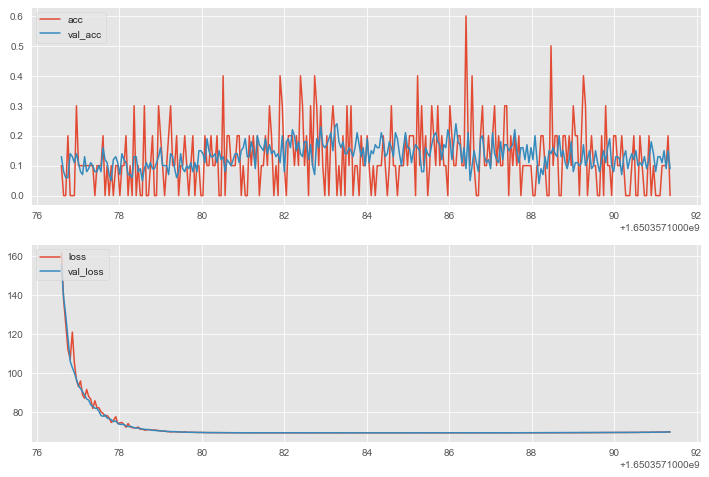

In [13]:
%matplotlib inline 

import matplotlib.pyplot as plt
from matplotlib import style

# Multiple lines

style.use('ggplot')
# t = open('model.log', 'r').read().split('\n')
# model_name = t[0][0:16]
# print(model_name)
model_name = MODEL_NAME

def create_acc_loss_graph(model_name):
    contents = open(f'{MODEL_NAME}.log', 'r').read().split('\n')

    times= []
    accuracies = []
    losses = []
    val_accs = []
    val_losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss = c.split(',')

            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))
            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))

            
    print(len(accuracies))
    fig = plt.figure(figsize=(12,8))

    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex = ax1)

    ax1.plot(times, accuracies, label = 'acc')
    ax1.plot(times, val_accs, label = 'val_acc')
    ax1.legend(loc=2)

    ax2.plot(times, losses, label = 'loss')
    ax2.plot(times, val_losses, label = 'val_loss')
    ax2.legend(loc=2)

    plt.show()

create_acc_loss_graph(model_name)

In [7]:
def main_train(model, trainloader, optimizer, initialized_loss, c=1.0):
    # Set mode to training.
    model.train()
    avgloss, avglosscount, newloss, acc, newacc = 0., 0., 0., 0., 0.

    # Go over all batches.
    for bidx, (data, target) in enumerate(trainloader):
        # bidx: Number of batches -> reaches from 0 - len(trainloader)
        # dara: btach_size tensors
        # Target: A tensor containing numbers from 0-100 (sice its cifar 100, I assume these
        # are the numbers of the class - basically the target and the y in my code)

        # Data to device.
        target_tmp = target
        target = model.polars[target]
        data = torch.autograd.Variable(data)
        target = torch.autograd.Variable(target)
        # Compute outputs and losses.
        output = model(data)
        output_exp_map = pmath.expmap0(output, c=c)

        loss_function = initialized_loss(output_exp_map, target)

        # Backpropagation.
        optimizer.zero_grad()
        loss_function.backward()
        optimizer.step()

        avgloss += loss_function.item()
        avglosscount += 1.
        newloss = avgloss / avglosscount

        output = model.predict(output_exp_map).float()
        pred = output.max(1, keepdim=True)[1]
        acc += pred.eq(target_tmp.view_as(pred)).sum().item()

    trainlen = len(trainloader.dataset)
    newacc = acc / float(trainlen)

    # I am returning new loss to show in the tensorboard!
    return newacc, newloss


def main_test(model, testloader, initialized_loss, c=1.0):
    # Set model to evaluation and initialize accuracy and cosine similarity.
    model.eval()
    acc = 0
    loss = 0

    # Go over all batches.
    with torch.no_grad():
        for data, target in testloader:
            # Data to device.
            data = torch.autograd.Variable(data)
            target = target.cuda(non_blocking=True)
            target = torch.autograd.Variable(target)
            target_loss = model.polars[target]

            # Forward.
            output = model(data).float()
            output_exp_map = pmath.expmap0(output, c=c)

            output = model.predict(output_exp_map).float()
            pred = output.max(1, keepdim=True)[1]
            acc += pred.eq(target.view_as(pred)).sum().item()

            loss += initialized_loss(output_exp_map, target_loss)

    # Print results.
    testlen = len(testloader.dataset)

    avg_acc = acc / float(testlen)
    avg_loss = loss / float(testlen)

    return avg_acc, avg_loss

In [8]:
model = resnet_cifar.ResNet(32, output_dims, 1, classpolars)
model = model
learning_rate = 1e-3
momentum = 0.0001
decay = 0.001
epochs = 3
penalty = 0.1
drop1 = 1
drop2 = 2
do_decay = True
log_dir = '/Users/dj/Documents/GitHub/Master_Thesis/Code/ImageNet_HBL'
writer = SummaryWriter(log_dir=log_dir)

choose_penalty = 'dim'
mult = 0.1
loss_function = PeBusePenalty(output_dims, penalty_option= choose_penalty, mult=mult) # 
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
optimizer = 'adam'

print('First time model initialization.')

# Load the optimizer.
optimizer = get_optimizer(optimizer, model.parameters(), learning_rate, momentum, decay)

# Initialize the loss functions.
choose_penalty = penalty
f_loss = PeBusePenalty(output_dims, penalty_option=choose_penalty, mult=mult)

# Main loop.
testscores = []
learning_rate = learning_rate
for i in range(epochs):
    print(i)

    # Learning rate decay.
    if i in [drop1, drop2] and do_decay:
        learning_rate *= 0.1
        for param_group in optimizer.param_groups:
            param_group['lr'] = learning_rate

    # Train and test.
    acc, loss = main_train(model, trainset, optimizer, f_loss, c=curvature)

    # add the train loss to the tensorboard writer
    writer.add_scalar("Loss/train", loss, i)
    writer.add_scalar("Accuracy/train", acc, i)

    if i != 0 and (i % 10 == 0 or i == epochs - 1): # i % 10
        test_acc, test_loss = main_test(model, testset, f_loss, c=curvature)

        testscores.append([i, test_acc])

        writer.add_scalar("Loss/test", test_loss, i)
        writer.add_scalar("Accuracy/test", test_acc, i)

writer.flush()
writer.close()

First time model initialization.
~~~~~~~~!Your option is not available, I am choosing!~~~~~~~~
0


KeyboardInterrupt: 